# Understanding the in-situ Solar Wind Properties with Machine Learning and Artificial Intelligence


Project Abstract: 
With the rapid increase of the in-situ measurements of the solar wind plasma, traditional data analysis methods are no longer sufficient for Heliophysics scientists to fully comprehend the scientific insights embedded within the data. Applications of Machine learning (ML) and Artificial Intelligence (AI) techniques on the solar data in order to perform feature selection, dimension reduction and clustering is the major goal of this proposal.


# Descriptive analytics

In [1]:
import pandas as pd
import re
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
#Read CSVs

#Just HCS
hcs_df = pd.read_csv('../data/HCS Cleaned.csv')
hcs_df['actual_date'] = pd.to_datetime(hcs_df['actual_date'])  

#HCS + Sunspots
hcs_sun = pd.read_csv("../data/HCS + Sunspots.csv")
hcs_sun['date'] = pd.to_datetime(hcs_sun['date']) 

#HCS + Sinsports + ACE
hcs_sun_ace= pd.read_csv("../data/HCS + Sunspots + ACE.csv")
hcs_sun_ace['date'] = pd.to_datetime(hcs_sun_ace['date']) 

### Creating visualization to explore the relationship between the indeces and the sunspots numbers

In [3]:
#Better scale to compare to sunspots
hcs_sun['SD_70*10'] = hcs_sun['SD_70']*10

#Creating a date colum  for the x axis
hcs_sun['date'] = pd.to_datetime(hcs_sun['year'].astype(str) + '-' + hcs_sun['month'].astype(str) + '-01')

hcs_sun

,year,month,SD_70,SL_70,SL_70_log10,fyear_CS,monthly_sunspots,std,observations,date,smoothed_sunspots,cycle,SD_70*10
0,1976,6,4.432569,26.940952,1.430413,1976.456,17.9,2.9,30,1976-06-01,49.753333,21,44.32569
1,1976,7,4.316492,20.119915,1.303626,1976.540,2.9,1.2,31,1976-07-01,52.096667,21,43.16492
2,1976,8,5.729208,22.427944,1.350681,1976.624,24.1,3.3,31,1976-08-01,55.371667,21,57.29208
3,1976,9,4.522666,24.674475,1.392248,1976.708,20.0,3.0,30,1976-09-01,57.995000,21,45.22666
4,1976,10,4.935369,30.268057,1.480985,1976.791,29.7,3.7,31,1976-10-01,60.735000,21,49.35369
...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,2022,1,15.485814,125.913376,2.100072,2022.042,55.3,11.2,1176,2022-01-01,NaN,25,154.85814
548,2022,2,14.926923,155.163116,2.190788,2022.122,60.9,11.1,1146,2022-02-01,NaN,25,149.26923
549,2022,3,15.028467,2146.650391,3.331761,2022.204,78.6,14.0,1413,2022-03-01,NaN,25,150.28467
550,2022,4,21.638395,639.182678,2.805625,2022.286,84.0,15.3,1376,2022-04-01,NaN,25,216.38395


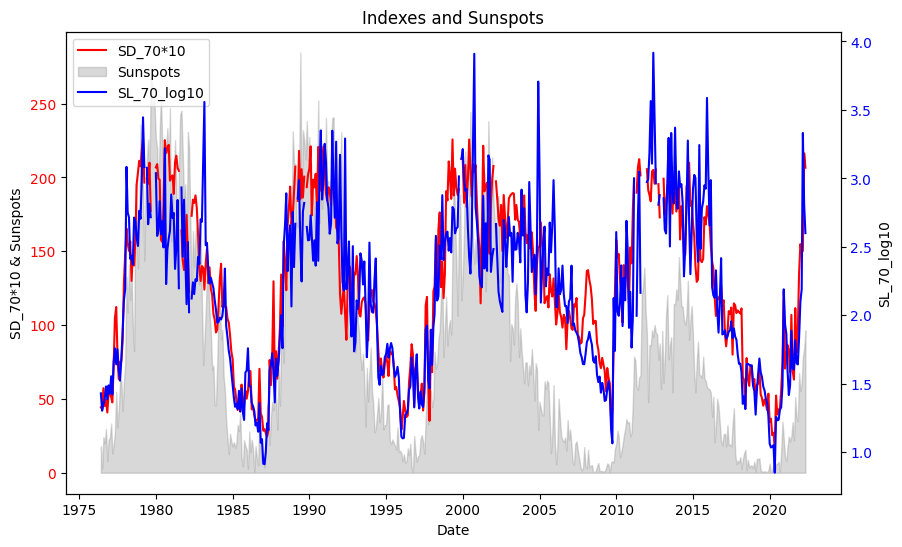

In [4]:
# Creating the figure and primary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting SD_70*10 on the primary y-axis
ax1.plot(hcs_sun['date'], hcs_sun['SD_70*10'], label='SD_70*10', color='red')

# Setting the label for the primary y-axis
ax1.set_ylabel('SD_70*10 & Sunspots')
ax1.tick_params(axis='y', labelcolor='red')

# Creating the secondary y-axis
ax2 = ax1.twinx()  

# Plotting SL_70_log10 on the secondary y-axis
ax2.plot(hcs_sun['date'], hcs_sun['SL_70_log10'], label='SL_70_log10', color='blue')

# Setting the label for the secondary y-axis
ax2.set_ylabel('SL_70_log10')
ax2.tick_params(axis='y', labelcolor='blue')

# Plotting the area plot for monthly_sunspots on the primary y-axis for simplicity
ax1.fill_between(hcs_sun['date'], hcs_sun['monthly_sunspots'], color='gray', alpha=0.3, label='Sunspots')

# Customization
ax1.set_xlabel('Date')
ax1.set_title('Indexes and Sunspots')

# Handling legends. Since we have plots on two different axes, handle them separately
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

### Baseline using Moving Average

In [5]:
#Window
N = 4

#Creating Moving Average Columns
hcs_sun_ace['moving_average_SD_70'] = hcs_sun_ace['SD_70'].rolling(window=N).mean()
hcs_sun_ace['moving_average_SL_70_log10'] = hcs_sun_ace['SL_70_log10'].rolling(window=N).mean()

In [6]:
hcs_sun_ace.head()

,year,month,SD_70,SL_70,SL_70_log10,fyear_CS,monthly_sunspots,std,observations,date,...,cycle,SD_70*10,proton_density,proton_temp,He4toprotons,proton_speed,PC1,PC2,moving_average_SD_70,moving_average_SL_70_log10
0,1998,2,12.301438,82.789337,1.917974,1998.123,50.2,4.6,559,1998-02-01,...,23,123.014380,10.668186,55818.621443,0.022320,377.004722,-1.249865,-0.740865,NaN,NaN
1,1998,3,12.602894,159.079344,2.008504,1998.204,82.0,5.9,571,1998-03-01,...,23,126.028935,9.296941,71053.688126,0.030932,402.813548,-0.854332,-0.273900,NaN,NaN
2,1998,4,15.813673,380.628082,2.580501,1998.288,70.6,7.2,537,1998-04-01,...,23,158.136730,8.991568,71262.155483,0.037028,379.456547,-1.017707,-0.005488,NaN,NaN
3,1998,5,12.578657,128.306992,2.108250,1998.371,74.0,4.8,620,1998-05-01,...,23,125.786570,6.943908,100056.671947,0.031098,452.484785,-0.047913,-0.120904,13.324165,2.153807
4,1998,6,16.536440,138.153671,2.140362,1998.455,90.5,6.0,521,1998-06-01,...,23,165.364400,8.368127,69987.706731,0.024842,414.453910,-0.684110,-0.465511,14.382916,2.209404


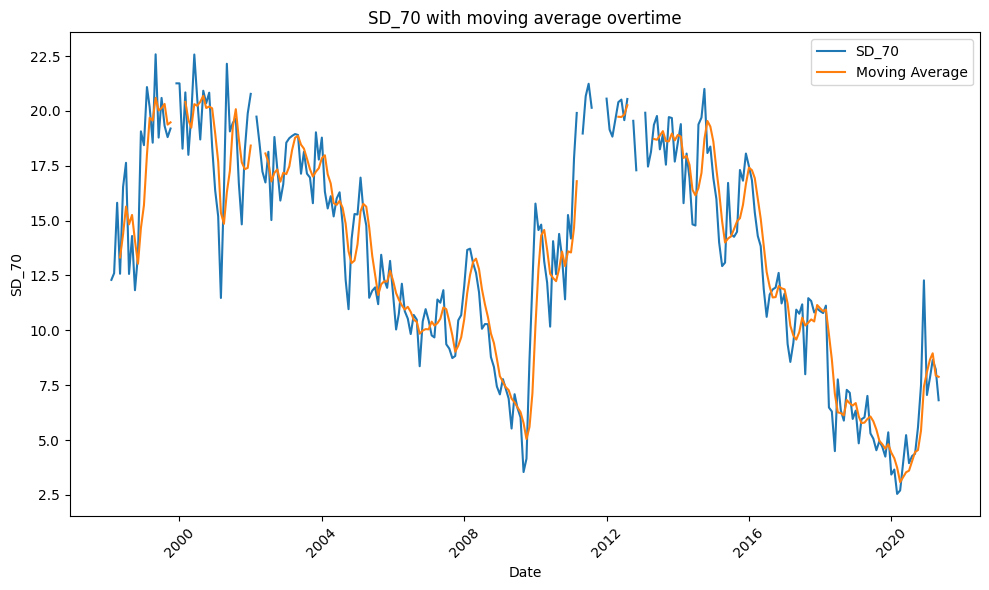

In [7]:
plt.figure(figsize=(10, 6))  # Setting the figure size
plt.plot(hcs_sun_ace['date'], hcs_sun_ace['SD_70'], label='SD_70')  # Plot series 1
plt.plot(hcs_sun_ace['date'], hcs_sun_ace['moving_average_SD_70'], label='Moving Average')  # Plot series 2

# Formatting the plot
plt.title('SD_70 with moving average overtime')
plt.xlabel('Date')
plt.ylabel('SD_70')
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

# Display the plot
plt.show()

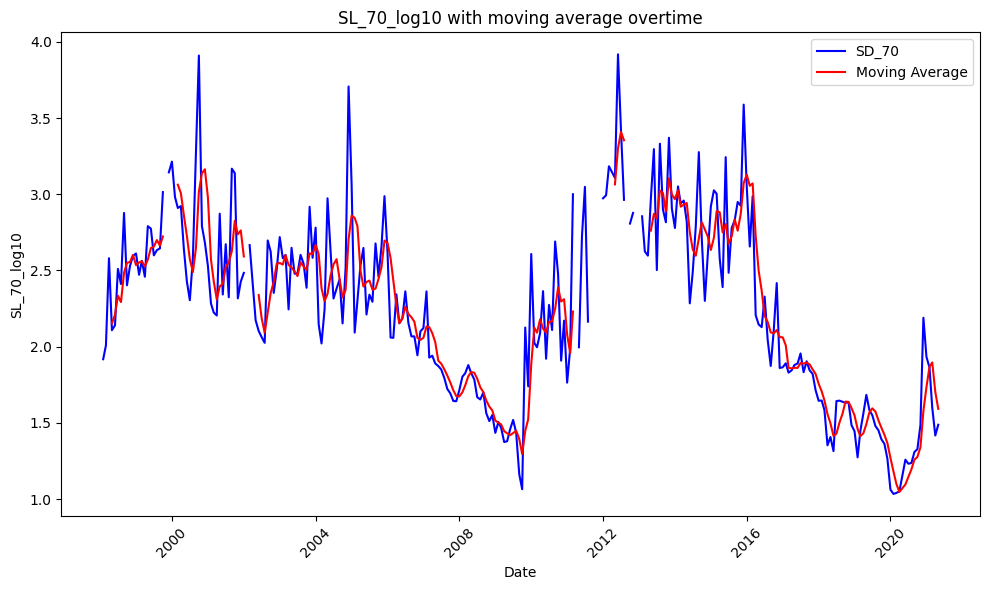

In [8]:
plt.figure(figsize=(10, 6))  # Setting the figure size
plt.plot(hcs_sun_ace['date'], hcs_sun_ace['SL_70_log10'], label='SD_70', color='blue')  # Plot series 1
plt.plot(hcs_sun_ace['date'], hcs_sun_ace['moving_average_SL_70_log10'], label='Moving Average', color='red')  # Plot series 2

# Formatting the plot
plt.title('SL_70_log10 with moving average overtime')
plt.xlabel('Date')
plt.ylabel('SL_70_log10')
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

# Display the plot
plt.show()

# Seasonal Decomposition

In [9]:
#Creating function to get seasonal decomposition, which we learned on Data Mining II

def sea_decomp(ser, model="additive"):
    """
    Takes in a series and a "model" parameter indicating which seasonal decomp to perform
    """
    result = seasonal_decompose(ser, model=model)
    
    return result


In [10]:
hcs_sun_ace_decomp = hcs_df.copy()

# Convert 'date' to datetime and set as index
hcs_sun_ace_decomp['date'] = pd.to_datetime(hcs_sun_ace_decomp['actual_date'])
hcs_sun_ace_decomp.set_index('date', inplace=True)

# Set the frequency of the index to monthly
hcs_sun_ace_decomp = hcs_sun_ace_decomp.asfreq('ME')

# Filling missing values in a way that avoids future issues
hcs_sun_ace_decomp['SD_70'] = hcs_sun_ace_decomp['SD_70'].fillna(0)
hcs_sun_ace_decomp['SL_70_log10'] = hcs_sun_ace_decomp['SD_70'].fillna(0)

Text(0.513, 0.95, 'HCS')

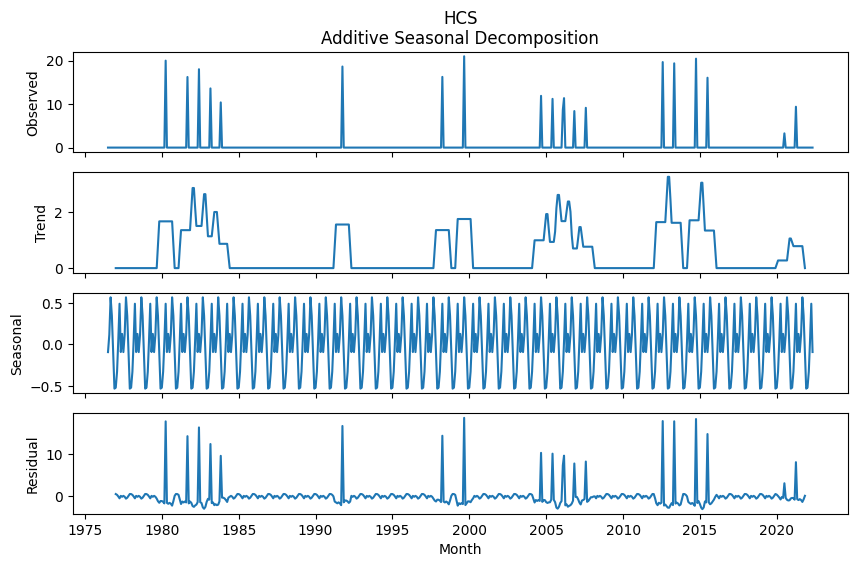

In [11]:
#Plotting seasonal decomposition
fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)
res = sea_decomp(hcs_sun_ace_decomp['SD_70'], model="additive")

axes[0].set_title("Additive Seasonal Decomposition")
axes[0].plot(res.observed)
axes[0].set_ylabel("Observed")

axes[1].plot(res.trend)
axes[1].set_ylabel("Trend")

axes[2].plot(res.seasonal)
axes[2].set_ylabel("Seasonal")

axes[3].plot(res.resid)
axes[3].set_ylabel("Residual")

axes[3].set_xlabel("Month")
fig.suptitle("HCS", x=0.513, y=0.95)

Text(0.513, 0.95, 'HCS Indexes')

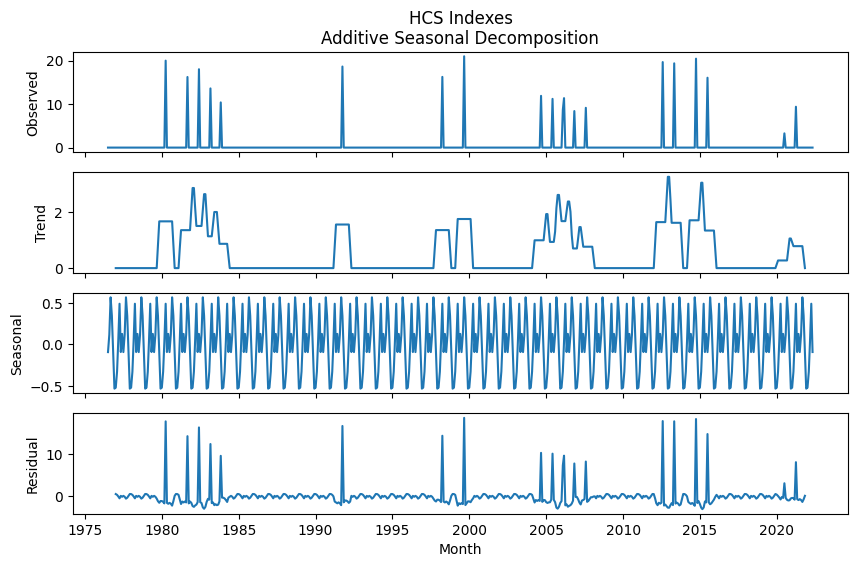

In [12]:
#Plotting seasonal decomposition
fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)
res = sea_decomp(hcs_sun_ace_decomp['SL_70_log10'], model="additive")

axes[0].set_title("Additive Seasonal Decomposition")
axes[0].plot(res.observed)
axes[0].set_ylabel("Observed")

axes[1].plot(res.trend)
axes[1].set_ylabel("Trend")

axes[2].plot(res.seasonal)
axes[2].set_ylabel("Seasonal")

axes[3].plot(res.resid)
axes[3].set_ylabel("Residual")

axes[3].set_xlabel("Month")
fig.suptitle("HCS Indexes", x=0.513, y=0.95)

Analysis:

It's similar for both dependent variables. What we gathered from this is the time series has a pronounced seasonal pattern, with a trend component that shows occasional significant deviations from the norm. The residual component mostly lies around the zero line with some sporadic spikes, which might represent random or irregular effects not explained by the seasonality or trend.

# Autocorrelation

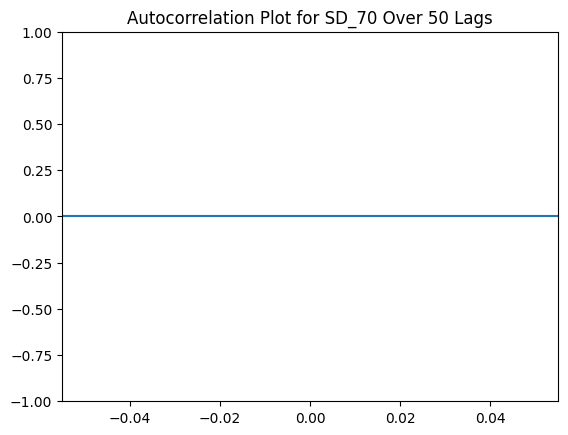

In [13]:
# Sample data: Replace this with your actual DataFrame column
data = hcs_df['SD_70']

# Plotting the Autocorrelation
plot_acf(data, lags=50)
plt.title("Autocorrelation Plot for SD_70 Over 50 Lags")
plt.show()


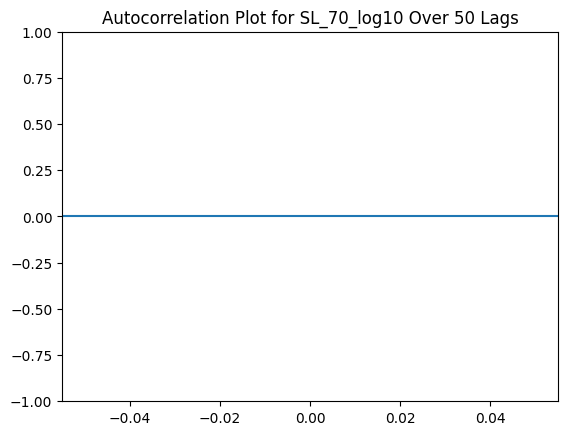

In [14]:
# Sample data: Replace this with your actual DataFrame column
data = hcs_df['SL_70_log10']

# Plotting the Autocorrelation
plot_acf(data, lags=50)
plt.title("Autocorrelation Plot for SL_70_log10 Over 50 Lags")
plt.show()


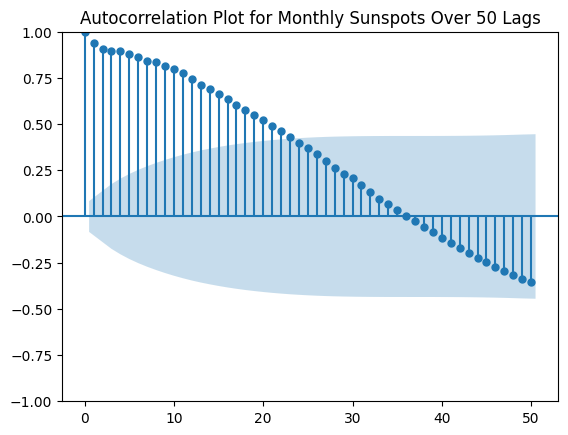

In [15]:
data = hcs_sun['monthly_sunspots']

# Plotting the Autocorrelation
plot_acf(data, lags=50)
plt.title("Autocorrelation Plot for Monthly Sunspots Over 50 Lags")
plt.show()

Seems like the outcome variables don't have autocorrelation but sunspot numbers do. This is interesting considering the results from the seasonal decomposition, which may have to do with the data pre=processing.

The sunspots autocorrelation plot indicates a strong, cyclical pattern in the monthly sunspot data, which is consistent with known solar cycle behavior. The data is positively correlated at shorter lags, with the correlation diminishing and sometimes becoming negative as the lags increase, reflecting the cyclical nature of sunspot activity.